In [1]:
import tmol.score.ljlk.numba.lj
display({"text/markdown" : tmol.score.ljlk.numba.lj.__doc__}, raw=True)


# Baseline LJ implementation

(From Alford et al with revisions.)

Van der Waals (VdW) interactions are short-range attractive and repulsive
forces that vary with atom-pair distance.  Whereas attractive forces result
from the cross-correlated motions of electrons in neighboring nonbonded atoms,
repulsive forces occur because electrons cannot occupy the same orbitals by the
Pauli exclusion principle.

To model VdW interactions, Rosetta uses the Lennard-Jones (LJ) 6−12 potential
calculating the interaction energy of atoms i and j given:

- The sum of atomic radii: ${\sigma}_{i,j} = \sigma_i + \sigma_j $.
- The geometric mean of well depths: ${\epsilon}_{i,j} = \sqrt{\epsilon_i \epsilon_j}$.
- The atom-pair distance: $d_{i,j}$.

$$
f_{vdw}(i, j) = {\epsilon}_{i,j} \left[
    \left(\frac{\sigma_{i,j}}{d_{i,j}} \right)^{13}
    - 2 \left(\frac{\sigma_{i,j}}{d_{i,j}} \right) ^ {6}
\right]
$$

The atomic radii and well depths are derived from small molecule liquid-phase
data optimized in the context of the energy model.
Note that in this form $\sigma$ is equivalent to an $r_{min}$  such that
$\sigma  = d \left| f_{vdw}(d) = \operatorname{min}{f_{vdw}(d)} \right.$ rather
than the traditional $\sigma  = d \left| f_{vdw}(d) = 0\right. $.

To accomodate the partially-covalent behavior of hydrogen bonds, $\sigma_{i,j}$
is adjusted for donor/acceptor and hydrogen/acceptor pairs:

$$
\sigma_{i,j} = \sigma_{j,i} = \left\{
\begin{array}{ll}
  \sigma_{hbond\_dis} &
    \left| i \in \{donor\}, i \notin \{hydroxyl\}, j \in \{acceptor\} \right. \\
  \sigma_{hbond\_OH\_donor\_dis} &
    \left| i \in \{donor\}, i \in \{hydroxyl\}, j \in \{acceptor\} \right. \\
  \sigma_{hbond\_H\_dis} &
    \left| i \in \{polar\_H\}, j \in \{acceptor\} \right. \\
  \sigma_{i} + \sigma_{j}
\end{array}
\right.
$$


At short distances, the $d_{i,j}^{-12}$ term can cause poor performance in
minimization and scoring due to high magnitude derivative and score values.  To
alleviate this problem the potential is linearly extrapolated for $ d_{i,j} <
.6{\sigma}_{i,j}$.  To accomodate efficient truncated evaluation, the potential
is defined as 0 for $d_{i,j} >= 6Å$.  Cubic polynomial interpolation
$f_{cpoly}$ is used to smoothly transition for a final piecewise definition:

$$
vdw_{i,j}\left(d_{i,j} \right) = \left\{
\begin{array}{ll}
  f^{\prime}_{vdw}(d_{lin}) \cdot \left(d_{i,j} - d_{lin}\right) + f_{vdw}(d_{lin})  &
      d_{i,j} \in [ 0Å, d_{lin} ) \\
  f_{vdw}(d_{i,j}) &
      d_{i,j} \in [ d_{lin}, 4.5Å ) \\
  f_{cpoly}(d_{i,j}) &
      d_{i,j} \in [ 4.5Å, 6.0Å) \\
  0 &
      d_{i,j} \in [ 6.0Å, +\infty ) \\
\end{array}
\right|
\begin{array}{ll}
  d_{lin} = .6 {\sigma}_{i,j} \\
  f_{cpoly}(4.5Å) = f_{vdw}(4.5Å), \,
  f^\prime_{cpoly}(4.5Å) = f^\prime_{vdw}(4.5Å) \\
  f_{cpoly}(6.0Å) = 0, \,
  f^\prime_{cpoly}(6.0Å) = 0 \\
\end{array}
$$


In [3]:
import numpy
from matplotlib import pylab

import tmol.database
from tmol.score.ljlk.numba.lj import lj, d_lj_d_dist

In [4]:
params = tmol.database.ParameterDatabase.get_default().scoring.ljlk

i = params.atom_type_parameters[0]
j = params.atom_type_parameters[2]

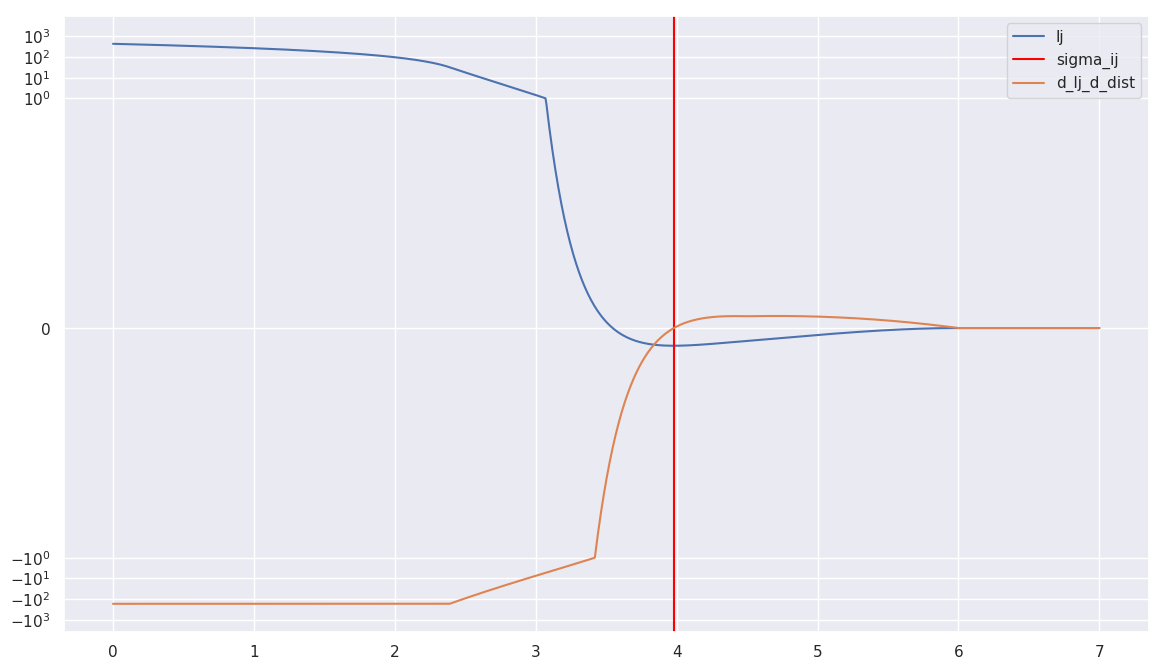

In [5]:
ds = numpy.linspace(0, 7, 1000)

pylab.plot(
    ds,
    lj(
        ds,
        i.lj_radius,
        i.lj_wdepth,
        i.is_donor,
        i.is_hydroxyl,
        i.is_polarh,
        i.is_acceptor,
        j.lj_radius,
        j.lj_wdepth,
        j.is_donor,
        j.is_hydroxyl,
        j.is_polarh,
        j.is_acceptor,
        params.global_parameters.lj_hbond_dis,
        params.global_parameters.lj_hbond_OH_donor_dis,
        params.global_parameters.lj_hbond_hdis,
    ),
    label="lj",
)
pylab.axvline(i.lj_radius + j.lj_radius, color="red", label=r"sigma_ij")

pylab.plot(
    ds,
    d_lj_d_dist(
        ds,
        i.lj_radius,
        i.lj_wdepth,
        i.is_donor,
        i.is_hydroxyl,
        i.is_polarh,
        i.is_acceptor,
        j.lj_radius,
        j.lj_wdepth,
        j.is_donor,
        j.is_hydroxyl,
        j.is_polarh,
        j.is_acceptor,
        params.global_parameters.lj_hbond_dis,
        params.global_parameters.lj_hbond_OH_donor_dis,
        params.global_parameters.lj_hbond_hdis,
    ),
    label="d_lj_d_dist",
)

pylab.legend(loc="best")
pylab.yscale("symlog", linthreshy=1, linscaley=10)